# 导入包

In [30]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# myseed = 42069
myseed = 4
np.random.seed(myseed)
# 保持可复现性：
torch.backends.cudnn.deterministic = True

# 因此方便复现、提升训练速度就：
torch.backends.cudnn.benchmark = False

torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# 工具包

In [31]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# 设置数据集

In [32]:
def swap(target):
    ans = []
    for i in target:
        a = np.zeros(10)
        a[i] = 1
        ans.append(a)
    return ans


class MnistDataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode
        data = pd.read_csv(path, header=None)
        data = np.array(data)
        feats = []
        if not target_only:
            feats = []

        if mode == 'test':
            self.data = torch.FloatTensor(data[:, 1:])
        else:
            target = data[:, 0]
            data = data[:, 1:]
            indices = []
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            self.data = torch.Tensor(data[indices] / 255)

            self.target = torch.Tensor(swap(target[indices]))

        self.dim = self.data.shape[1]
        print('Finished reading the {} set of mnist Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, item):
        if self.mode in ['train', 'dev']:
            return self.data[item], self.target[item]
        else:
            return self.data[item]

    def __len__(self):
        return len(self.data)

# 数据加载

In [33]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = MnistDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)  # Construct dataloader
    return dataloader

# 神经网络

In [34]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''

    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        return self.criterion(pred, target)

# 训练函数

In [35]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''
    n_epochs = config['n_epochs']  # Maximum number of epochs
    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}  # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()  # set model to training mode
        for x, y in tr_set:  # iterate through the dataloader
            optimizer.zero_grad()  # set gradient to zero
            x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
            pred = model(x)  # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()  # compute gradient (backpropagation)
            optimizer.step()  # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

# 验证函数

In [36]:
def dev(dv_set, model, device):
    model.eval()  # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:  # iterate through the dataloader
        x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)  # compute averaged loss

    return total_loss

# 测试函数

In [37]:
def test(tt_set, model, device):
    model.eval()  # set model to evalutation mode
    preds = []
    for x in tt_set:  # iterate through the dataloader
        x = x.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            preds.append(pred.detach().cpu())  # collect prediction
    preds = torch.cat(preds, dim=0).numpy()  # concatenate all predictions and convert to a numpy array
    return preds

# 设置超参数

In [38]:
device = get_device()  # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False  # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    # 总共训练多少次
    'n_epochs': 3000,  # maximum number of epochs
    'batch_size': 270,  # mini-batch size for dataloader
    'optimizer': 'SGD',  # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {  # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,  # learning rate of SGD
        'momentum': 0.9  # momentum for SGD
    },
    'early_stop': 200,  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': '../models/model.pth'  # your model will be saved here
}
getattr(torch.optim, config['optimizer'])

torch.optim.sgd.SGD

# 加载数据

In [39]:
tr_path = '../data/mnist_train.csv'  # path to training data
tt_path = '../data/mnist_test.csv'  # path to testing data
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of mnist Dataset (54000 samples found, each dim = 784)
Finished reading the dev set of mnist Dataset (6000 samples found, each dim = 784)
Finished reading the test set of mnist Dataset (10000 samples found, each dim = 784)


In [40]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [41]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 0.0853)
Saving model (epoch =    2, loss = 0.0786)
Saving model (epoch =    3, loss = 0.0730)
Saving model (epoch =    4, loss = 0.0682)
Saving model (epoch =    5, loss = 0.0643)
Saving model (epoch =    6, loss = 0.0612)
Saving model (epoch =    7, loss = 0.0587)
Saving model (epoch =    8, loss = 0.0567)
Saving model (epoch =    9, loss = 0.0550)
Saving model (epoch =   10, loss = 0.0535)
Saving model (epoch =   11, loss = 0.0522)
Saving model (epoch =   12, loss = 0.0511)
Saving model (epoch =   13, loss = 0.0501)
Saving model (epoch =   14, loss = 0.0492)
Saving model (epoch =   15, loss = 0.0483)
Saving model (epoch =   16, loss = 0.0476)
Saving model (epoch =   17, loss = 0.0469)
Saving model (epoch =   18, loss = 0.0462)
Saving model (epoch =   19, loss = 0.0456)
Saving model (epoch =   20, loss = 0.0451)
Saving model (epoch =   21, loss = 0.0446)
Saving model (epoch =   22, loss = 0.0441)
Saving model (epoch =   23, loss = 0.0436)
Saving mode

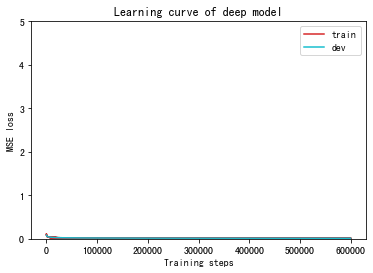

In [42]:
plot_learning_curve(model_loss_record, title='deep model')

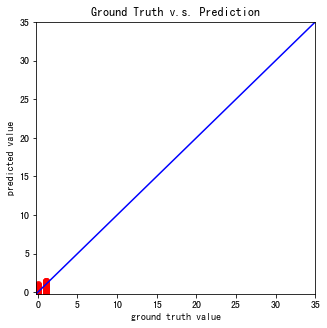

In [43]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [44]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])


preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')  # save prediction file to pred.csv

Saving results to pred.csv


In [45]:
import pandas as pd

tr = pd.read_csv('../data/mnist_train.csv', header=None)
tr.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
tr[0]

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: 0, Length: 60000, dtype: int64

In [47]:
a= np.zeros(10)
a[1]

0.0